# Diffusion Flame Extinction

This example documents the extinction point of counterflow diffusion flame. There is a flame created in between two potential flows, one from the oxidizer jet and one from the fuel jet. 

<img src="/images/cfdiffusion.png"/>

### Import Modules

In [1]:
%matplotlib notebook
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.3.0



### Create Directory for output data files

In [2]:
# Create directory for output data files
data_directory = 'diffusion_flame_extinction_data/'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

### Initialize hydrogen-oxygen counterflow

In [3]:
# Set up an initial hydrogen-oxygen counterflow flame at 1 bar and low strain
# rate (maximum axial velocity gradient = 2414 1/s)
reaction_mechanism = 'h2o2.xml'
gas = ct.Solution(reaction_mechanism)
width = 18.e-3 # 18mm wide
f = ct.CounterflowDiffusionFlame(gas, width=width)

### Define the operating pressure and boundary conditions

In [4]:
# Define the operating pressure and boundary conditions
f.P = 1.e5  # 1 bar
f.fuel_inlet.mdot = 0.5  # kg/m^2/s
f.fuel_inlet.X = 'H2:1'
f.fuel_inlet.T = 300  # K
f.oxidizer_inlet.mdot = 3.0  # kg/m^2/s
f.oxidizer_inlet.X = 'O2:1'
f.oxidizer_inlet.T = 500  # K

### Set refinement parameters

In [5]:
f.set_refine_criteria(ratio=3.0, slope=0.1, curve=0.2, prune=0.03)

### Define a limit for the maximum termperature below which the considered as extinguished and the computation is aborted

In [6]:
temperature_limit_extinction = 500 # K

### Initialize and solve

In [7]:
print('Creating the initial solution')
f.solve(loglevel=0, auto=True)

Creating the initial solution


### Save to data directory

In [8]:
file_name = 'initial_solution.xml'
f.save(data_directory + file_name, name='solution', description='Cantera cersion ' + ct.__version__ + ', reaction mechanism ' + reaction_mechanism)

Solution saved to file diffusion_flame_extinction_data/initial_solution.xml as solution solution.


## Part 2: COMPUTE EXTINCTION STRAIN

### Set exponents for the intial solution variation

In [9]:
# Exponents for the initial solution variation with changes in strain rate
# Taken from Fiala and Sattelmayer (2014)
exp_d_a = - 1. / 2.
exp_u_a = 1. / 2.
exp_V_a = 1.
exp_lam_a = 2.
exp_mdot_a = 1. / 2.

### Configure strain rate

In [10]:
# Set normalized initial strain rate
alpha = [1.]
# Initial relative strain rate increase
delta_alpha = 1.
# Factor of refinement of the strain rate increase
delta_alpha_factor = 50.
# Limit of the refinement: Minimum normalized strain rate increase
delta_alpha_min = .001
# Limit of the Temperature decrease
delta_T_min = 1  # K

### Set iteration, latest flame, peak temp, and max axial velocity gradients

In [11]:
# Iteration indicator
n = 0
# Indicator of the latest flame still burning
n_last_burning = 0
# List of peak temperatures
T_max = [np.max(f.T)]
# List of maximum axial velocity gradients
a_max = [np.max(np.abs(np.gradient(f.u) / np.gradient(f.grid)))]

### Simulate counterflow flames at increasing strain rates until the flame is extinguished.

In [12]:
# Simulate counterflow flames at increasing strain rates until the flame is
# extinguished. To achieve a fast simulation, an initial coarse strain rate
# increase is set. This increase is reduced after an extinction event and
# the simulation is again started based on the last burning solution.
# The extinction point is considered to be reached if the abortion criteria
# on strain rate increase and peak temperature decrease are fulfilled.
while True:
    n += 1
    # Update relative strain rates
    alpha.append(alpha[n_last_burning] + delta_alpha)
    strain_factor = alpha[-1] / alpha[n_last_burning]
    # Create an initial guess based on the previous solution
    # Update grid
    f.flame.grid *= strain_factor ** exp_d_a
    normalized_grid = f.grid / (f.grid[-1] - f.grid[0])
    # Update mass fluxes
    f.fuel_inlet.mdot *= strain_factor ** exp_mdot_a
    f.oxidizer_inlet.mdot *= strain_factor ** exp_mdot_a
    # Update velocities
    f.set_profile('u', normalized_grid, f.u * strain_factor ** exp_u_a)
    f.set_profile('V', normalized_grid, f.V * strain_factor ** exp_V_a)
    # Update pressure curvature
    f.set_profile('lambda', normalized_grid, f.L * strain_factor ** exp_lam_a)
    try:
        f.solve(loglevel=0)
    except Exception as e:
        # Throw Exception if solution fails
        print('Error: Did not converge at n =', n, e)
    if np.max(f.T) > temperature_limit_extinction:
        # Flame still burning, so go to next strain rate
        n_last_burning = n
        file_name = 'extinction_{0:04d}.xml'.format(n)
        f.save(data_directory + file_name, name='solution', loglevel=0,
               description='Cantera version ' + ct.__version__ +
               ', reaction mechanism ' + reaction_mechanism)
        T_max.append(np.max(f.T))
        a_max.append(np.max(np.abs(np.gradient(f.u) / np.gradient(f.grid))))
        # If the temperature difference is too small and the minimum relative
        # strain rate increase is reached, abort
        if ((T_max[-2] - T_max[-1] < delta_T_min) &
                (delta_alpha < delta_alpha_min)):
            print('Flame extinguished at n = {0}.'.format(n),
                  'Abortion criterion satisfied.')
            break
    else:
        # Procedure if flame extinguished but abortion criterion is not satisfied
        print('Flame extinguished at n = {0}. Restoring n = {1} with alpha = {2}'.format(
              n, n_last_burning, alpha[n_last_burning]))
        # Reduce relative strain rate increase
        delta_alpha = delta_alpha / delta_alpha_factor
        # Restore last burning solution
        file_name = 'extinction_{0:04d}.xml'.format(n_last_burning)
        f.restore(data_directory + file_name, name='solution', loglevel=0)


Flame extinguished at n = 283. Restoring n = 282 with alpha = 283.0
Flame extinguished at n = 296. Restoring n = 295 with alpha = 283.2399999999998
Flame extinguished at n = 297. Abortion criterion satisfied.


### Print parameters at the extinction point

In [13]:
print('----------------------------------------------------------------------')
print('Parameters at the extinction point:')
print('Pressure p={0} bar'.format(f.P / 1e5))
print('Peak temperature T={0:4.0f} K'.format(np.max(f.T)))
print('Mean axial strain rate a_mean={0:.2e} 1/s'.format(f.strain_rate('mean')))
print('Maximum axial strain rate a_max={0:.2e} 1/s'.format(f.strain_rate('max')))
print('Fuel inlet potential flow axial strain rate a_fuel={0:.2e} 1/s'.format(
      f.strain_rate('potential_flow_fuel')))
print('Oxidizer inlet potential flow axial strain rate a_ox={0:.2e} 1/s'.format(
      f.strain_rate('potential_flow_oxidizer')))
print('Axial strain rate at stoichiometric surface a_stoich={0:.2e} 1/s'.format(
      f.strain_rate('stoichiometric', fuel='H2')))

----------------------------------------------------------------------
Parameters at the extinction point:
Pressure p=1.0 bar
Peak temperature T= 500 K
Mean axial strain rate a_mean=1.59e+05 1/s
Maximum axial strain rate a_max=7.33e+05 1/s
Fuel inlet potential flow axial strain rate a_fuel=2.90e+05 1/s
Oxidizer inlet potential flow axial strain rate a_ox=9.38e+04 1/s
Axial strain rate at stoichiometric surface a_stoich=1.38e+05 1/s


### Plot

<IPython.core.display.Javascript object>


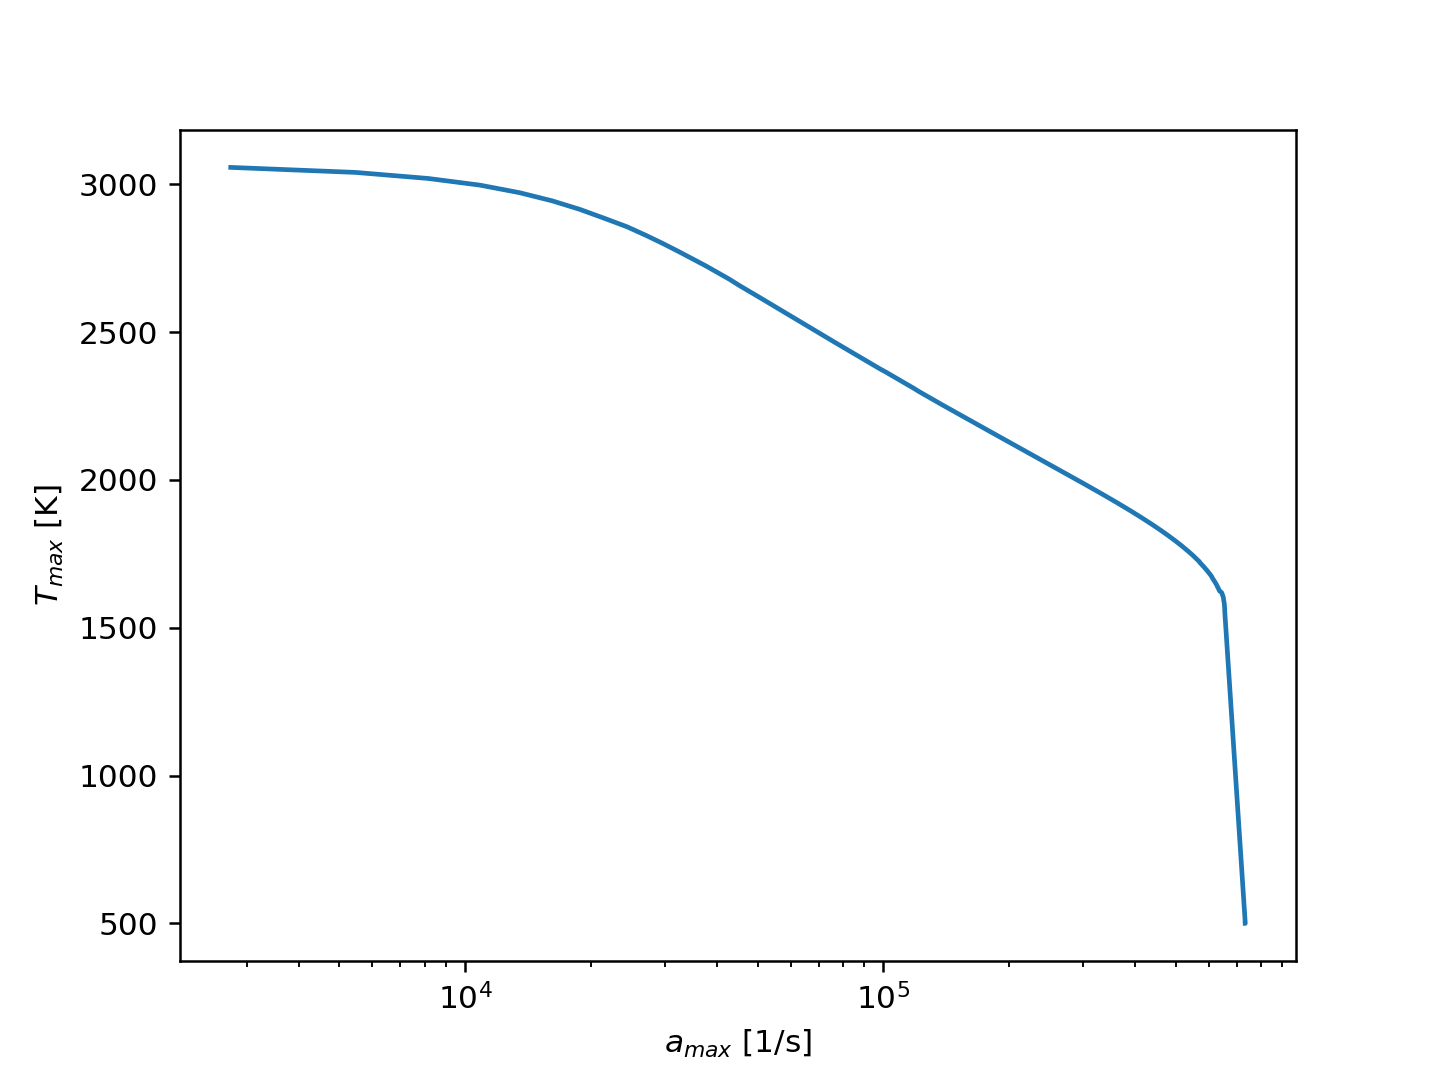

In [14]:
# Plot the maximum temperature over the maximum axial velocity gradient
plt.figure()
plt.semilogx(a_max, T_max)
plt.xlabel(r'$a_{max}$ [1/s]')
plt.ylabel(r'$T_{max}$ [K]')
plt.savefig(data_directory + 'figure_T_max_a_max.png')